In [1]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten


In [2]:
def extract_features(audio_file, sample_rate=22050):
    # Load audio file
    audio, sr = librosa.load(audio_file, sr=sample_rate)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)  # Taking mean over time for each coefficient
    return mfccs_scaled

# Path to dataset (replace with your dataset path)
dataset_path = r'C:\Users\202001342\Downloads\KAGGLE\AUDIO'

# Label your dataset files (real or fake)
labels = []
features = []
for folder in ['REAL', 'FAKE']:
    folder_path = os.path.join(dataset_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        features.append(extract_features(file_path))
        labels.append(folder)

# Convert to numpy array
features = np.array(features)
labels = np.array(labels)

# Encode the labels (real = 0, fake = 1)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)


In [4]:
# Reshape data for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Build 1D CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification (real or fake)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\202001342\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [5]:
# Train the model
history = model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5451 - loss: 1.8694 - val_accuracy: 0.7895 - val_loss: 0.5615
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5924 - loss: 1.5794 - val_accuracy: 0.4211 - val_loss: 1.0612
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5286 - loss: 1.7119 - val_accuracy: 0.6842 - val_loss: 0.5326
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4991 - loss: 1.3826 - val_accuracy: 0.6842 - val_loss: 0.5404
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5573 - loss: 1.4802 - val_accuracy: 0.6842 - val_loss: 0.5027
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6645 - loss: 1.0819 - val_accuracy: 0.6842 - val_loss: 0.4746
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5356 - loss: 0.8999 - val_accuracy: 0.6842 - val_loss: 0.5034
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6584 - loss: 0.9666 - val_accuracy: 0.6842 - val_loss: 0.4844


In [6]:
# Evaluate on test data
y_pred = model.predict(X_test_cnn)
y_pred_classes = (y_pred > 0.5).astype(int)

# Model evaluation metrics
print("Accuracy: ", accuracy_score(y_test, y_pred_classes))
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Accuracy:  0.8260869565217391
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.90      0.75      0.82        12

    accuracy                           0.83        23
   macro avg       0.83      0.83      0.83        23
weighted avg       0.84      0.83      0.83        23



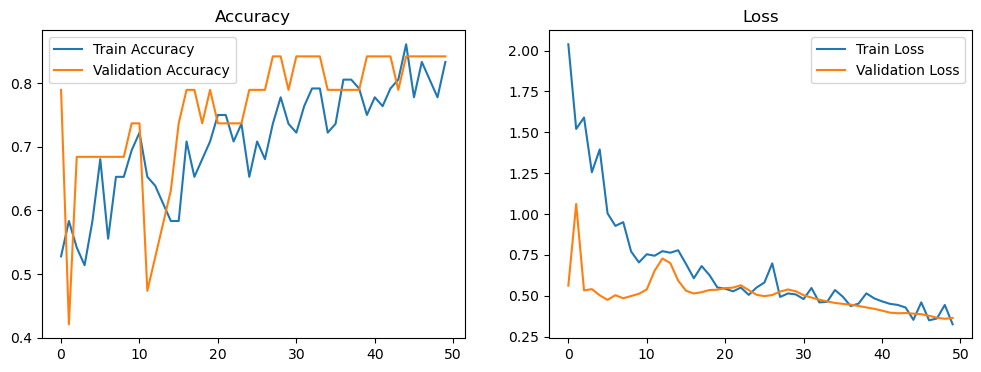

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [8]:
model.save('Deepfake_VoiceDetection_Model3.keras')